## Name: tdop_ppi.py

Author: Robby M. Frost

University of Oklahoma

Created: 23 September 23024

Purpose: Plotting terminal doppler PPIs of radial
velocity and inferred vertical vorticity

In [1]:
import pyart
# import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from metpy.plots import USCOUNTIES


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Read in radar data and add filter

In [2]:
# ---------------------------------
# read in radar file

# radar file location
# dfile = '/Users/robbyfrost/Documents/MS_Project/data_tmp/tokc/TOKC20240714_215057_V08'
dfile = '/home/robbyfrost/Analysis/TurbTor_Misc_Code/tokc_analysis/TOKC20240715_214211_V08'
figdir = '/home/robbyfrost/Analysis/TurbTor_Misc_Code/tokc_analysis/'

# read file
radar = pyart.io.read(dfile)
# extract radar position
radar_lat = radar.latitude['data'][0]
radar_lon = radar.longitude['data'][0]
# mask out last 10 gates of each ray, this removes the "ring" around the radar.
radar.fields["reflectivity"]["data"][:, -10:] = np.ma.masked
radar.fields["velocity"]["data"][:, -10:] = np.ma.masked
# exclude masked gates from the gridding
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_masked("reflectivity")
gatefilter.exclude_masked("velocity")

In [3]:
radar.fields.keys()

dict_keys(['spectrum_width', 'reflectivity', 'velocity'])

Calculate vertical vorticity

In [4]:
# extract needed arrays
vr = radar.fields['velocity']['data']
az = radar.azimuth['data']
r = radar.range['data']
# Mask out close ranges
r_masked = np.where(r < 1000, np.nan, r)
# calculate
vort_z = ( (vr[1:,:] - vr[:-1,:]) / (np.deg2rad(az[1:]) - np.deg2rad(az[:-1]))[:,np.newaxis] ) * (1 / r_masked)
# pad extra azimuth array
vort_z_padded = np.pad(vort_z, ((0, 1), (0, 0)), mode='constant', constant_values=np.nan)  # Add NaNs to the extra azimuth

Add $\zeta$ to radar object

In [5]:
# Create the new field dictionary
vort_z_field = {
    'data': vort_z_padded,
    'units': '/s',  # Example units
    'long_name': 'Inferred Vertical Vorticity',  # Long name for the field
    'standard_name': 'Vertical_Vocticity',  # Standard name
    # 'valid_min': -0.2,  # Optional, valid min value for the field
    # 'valid_max': 0.2,   # Optional, valid max value for the field
}

# Add the new field to the radar object
radar.add_field('vort_z', vort_z_field, replace_existing=True)
# gatefielter on vort_z
gatefilter.exclude_outside('vort_z', -0.05, 0.05)

Plot PPI of reflectivity and radial velocity

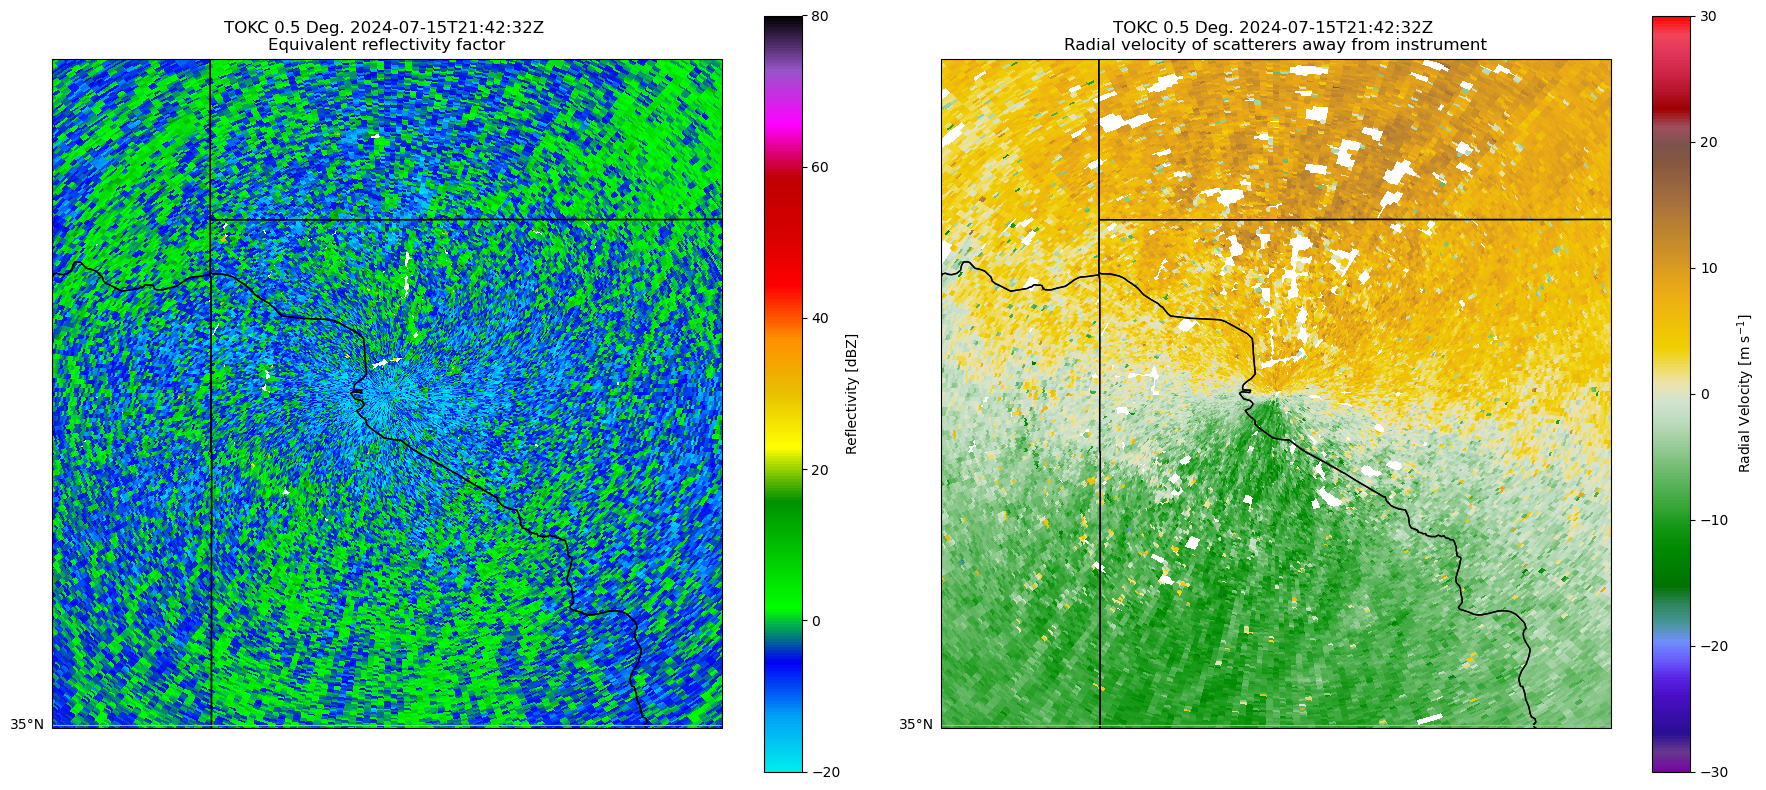

In [9]:
# ---------------------------------
# plot PPI of reflectivity and vr

# Create a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# First plot: Reflectivity on ax1
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(
    'reflectivity',
    sweep=1,
    ax=ax[0],
    cmap='pyart_NWSRef',
    vmin=-20, vmax=80,
    projection=ccrs.PlateCarree(),
    min_lon=radar_lon - 0.25, max_lon=radar_lon + 0.25,
    min_lat=radar_lat - 0.25, max_lat=radar_lat + 0.25,
    resolution='50m',
    # lat_lines=np.arange(int(radar_lat) - 2, int(radar_lat) + 2, 0.5),
    # lon_lines=np.arange(int(radar_lon) - 2, int(radar_lon) + 2, 0.5),
    colorbar_flag=True,
    colorbar_label='Reflectivity [dBZ]'
)

# Second plot: Radial Velocity on ax2
display.plot_ppi_map(
    'velocity',  # Field to plot, change as needed for your dataset
    sweep=1,
    ax=ax[1],
    cmap='pyart_Carbone42',  # Use a different colormap for velocity
    vmin=-30, vmax=30,  # Adjust min/max values for radial velocity
    projection=ccrs.PlateCarree(),
    min_lon=radar_lon - 0.25, max_lon=radar_lon + 0.25,
    min_lat=radar_lat - 0.25, max_lat=radar_lat + 0.25,
    resolution='50m',
    # lat_lines=np.arange(int(radar_lat) - 2, int(radar_lat) + 2, 0.5),
    # lon_lines=np.arange(int(radar_lon) - 2, int(radar_lon) + 2, 0.5),
    colorbar_flag=True,
    colorbar_label='Radial Velocity [m s$^{-1}$]',
    gatefilter=gatefilter
)

# mapping
for iax in ax:
    # iax.coastlines('50m')
    iax.add_feature(cfeature.STATES, linewidth=0.5)
    iax.add_feature(USCOUNTIES.with_scale('500k'))

# Display the plot
plt.tight_layout()
plt.savefig(f"{figdir}tokc_test.png")
plt.show()
plt.close()

Plot PPI of radial velocity and vertical vorticity

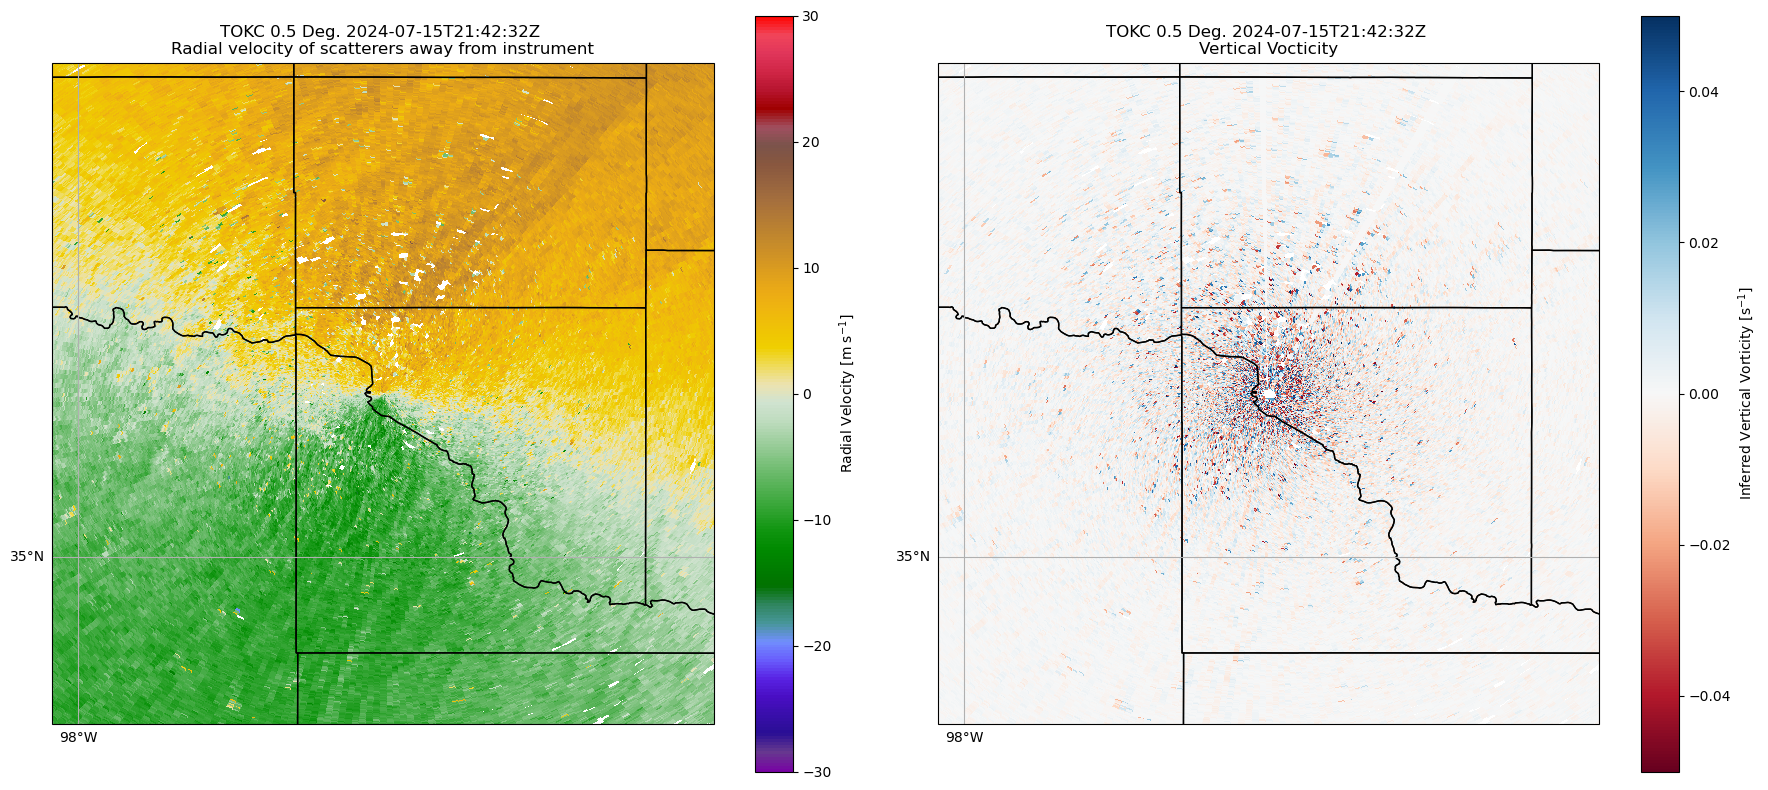

In [7]:
# ---------------------------------
# plot PPI of vr and vort_z

# Create a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# first plot: Radial Velocity on ax2
display.plot_ppi_map(
    'velocity',  # Field to plot, change as needed for your dataset
    sweep=1,
    ax=ax[0],
    cmap='pyart_Carbone42',  # Use a different colormap for velocity
    vmin=-30, vmax=30,  # Adjust min/max values for radial velocity
    projection=ccrs.PlateCarree(),
    min_lon=radar_lon - 0.5, max_lon=radar_lon + 0.5,
    min_lat=radar_lat - 0.5, max_lat=radar_lat + 0.5,
    resolution='50m',
    # lat_lines=np.arange(int(radar_lat) - 2, int(radar_lat) + 2, 0.5),
    # lon_lines=np.arange(int(radar_lon) - 2, int(radar_lon) + 2, 0.5),
    colorbar_flag=True,
    colorbar_label='Radial Velocity [m s$^{-1}$]',
    gatefilter=gatefilter
)

# second plot: inferred vertical vorticity
display.plot_ppi_map(
    'vort_z',
    sweep=1,
    ax=ax[1],
    cmap='RdBu',
    vmin=-0.05, vmax=0.05,
    projection=ccrs.PlateCarree(),
    min_lon=radar_lon - 0.5, max_lon=radar_lon + 0.5,
    min_lat=radar_lat - 0.5, max_lat=radar_lat + 0.5,
    resolution='50m',
    # lat_lines=np.arange(int(radar_lat) - 2, int(radar_lat) + 2, 0.5),
    # lon_lines=np.arange(int(radar_lon) - 2, int(radar_lon) + 2, 0.5),
    colorbar_flag=True,
    colorbar_label='Inferred Vertical Vorticity [s$^{-1}$]',
    gatefilter=gatefilter
)

# mapping
for iax in ax:
    # iax.coastlines('50m')
    iax.add_feature(cfeature.STATES, linewidth=0.5)
    iax.add_feature(USCOUNTIES.with_scale('500k'))

# Display the plot
plt.tight_layout()
plt.savefig(f"{figdir}tokc_test_vort_z.png")
plt.show()
plt.close()